##**GPU**

In [ ]:
!nvidia-smi

# **Install**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 15.2 MB/s eta 0:00:00


# **Imports 📢**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm
from prettytable import PrettyTable
from torchmetrics import Accuracy
import math


# **Utils 🧰**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Dataset 🗂️**

In [ ]:
!wget https://www.timeseriesclassification.com/aeon-toolkit/ECG5000.zip

--2024-09-17 15:28:51--  https://www.timeseriesclassification.com/aeon-toolkit/ECG5000.zip
Resolving www.timeseriesclassification.com (www.timeseriesclassification.com)... 212.78.75.243
Connecting to www.timeseriesclassification.com (www.timeseriesclassification.com)|212.78.75.243|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 10614407 (10M) [application/zip]
Saving to: ‘ECG5000.zip’

ECG5000.zip         100%[===================>]  10.12M  12.6MB/s    in 0.8s    

2024-09-17 15:28:52 (12.6 MB/s) - ‘ECG5000.zip’ saved [10614407/10614407]



In [ ]:
!unzip /content/ECG5000.zip

Archive:  /content/ECG5000.zip
  inflating: ECG5000.txt             
  inflating: ECG5000_TEST.arff       
  inflating: ECG5000_TEST.txt        
  inflating: ECG5000_TRAIN.arff      
  inflating: ECG5000_TRAIN.txt       
  inflating: ECG5000_TEST.ts         
  inflating: ECG5000_TRAIN.ts        


In [ ]:
# !cp /content/drive/MyDrive/deep_learning_homework8/ECG5000.zip /content/
# !unzip /content/ECG5000.zip

## Dataset

In [ ]:
train_file = '/content/ECG5000_TRAIN.txt'
test_file = '/content/ECG5000_TEST.txt'


train_data = pd.read_csv(train_file, delim_whitespace=True, header=None)
test_data = pd.read_csv(test_file, delim_whitespace=True, header=None)


X_train = train_data.iloc[:, 1:].values  # ویژگی‌ها
y_train = train_data.iloc[:, 0].values - 1    # برچسب‌ها

X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values -1


print(f"Training data shape num_sam*L: {X_train.shape}")
print(f"Test data shape num_sam*L: {X_test.shape}")


L = 140 #(sequence_length)
F = 1 #(feature)


X_train = X_train.reshape(-1, 140, 1)  # تبدیل داده‌های تمرین به شکل (num_Sam, L, F)
X_test = X_test.reshape(-1, 140, 1)    # تبدیل داده‌های تست به شکل (num_Sam, L, F)


print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

print(np.unique(y_train),np.unique(y_test))

Training data shape num_sam*L: (500, 140)
Test data shape num_sam*L: (4500, 140)
Training data shape: (500, 140, 1)
Test data shape: (4500, 140, 1)
[0. 1. 2. 3. 4.] [0. 1. 2. 3. 4.]


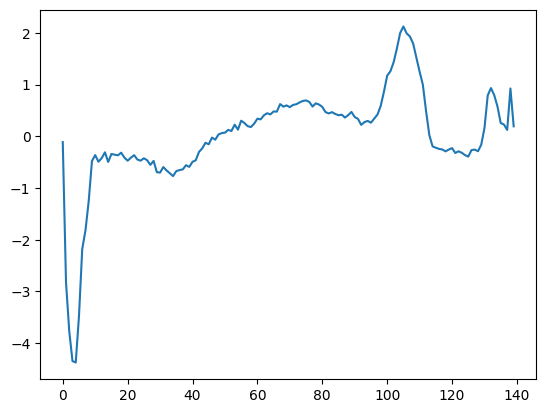

In [ ]:
plt.plot(X_train[0])

## DataLoader

In [ ]:
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



In [ ]:
train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
x_batch,y_batch = next(iter(train_loader))
x_batch.shape,y_batch.shape

(torch.Size([64, 140, 1]), torch.Size([64]))

# **Init ⚙️**

In [ ]:
num_cls = len(set(y_train))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **Model 🧠**

## TransformerModel

In [ ]:
class TransformerModel(nn.Module):

  def __init__(self, d_model, nhead, num_enc, dim_feed, dropout, activation):
    super().__init__()
    self.encoder = nn.Transformer(d_model,
                                  nhead,
                                  num_enc,
                                  0,
                                  dim_feed,
                                  dropout,
                                  activation,
                                  batch_first=True).encoder

    self.fc = nn.LazyLinear(num_cls)
    self.linear0 = nn.LazyLinear(d_model)
    self.bn0 = nn.LazyBatchNorm1d()

  def forward(self, x):
    x = self.bn0(self.linear0(x)).relu()
    y = self.encoder(x)

    y = self.fc(y[:, -1])

    # y = y.mean(dim =1)
    # y= self.fc(y)
    return y

In [ ]:
model = TransformerModel(d_model = 16, nhead = 4,  num_enc = 1, dim_feed = 4*16,dropout = 0.1, activation = 'relu').to(device)

# **Functions** 🧮

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task="multiclass", num_classes=5).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [ ]:
def validation(model, valid_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task="multiclass", num_classes=5).to(device)
    for i, (inputs, targets) in enumerate(valid_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

In [ ]:
x_batch = x_batch.to(device)
model = TransformerModel(d_model = 16, nhead = 4,  num_enc = 2, dim_feed = 4*16,dropout = 0.2, activation = 'relu').to(device)
model(x_batch).shape

torch.Size([64, 5])

In [ ]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())
  return nums

num_params(model)

6989

# **Efficient way for set hyperparams 🔨**

## Step 1: check forward path

Calculate loss for one batch

In [ ]:
model = TransformerModel(d_model = 16, nhead = 4,  num_enc = 2, dim_feed = 4*16,dropout = 0.2, activation = 'relu').to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(1.9882, grad_fn=<NllLossBackward0>)


## Step 2: check backward path

Select 5 random batches and train the model

In [ ]:
_, mini_train_dataset = random_split(train_dataset, (len(train_dataset)-100, 100))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
model = TransformerModel(d_model = 16, nhead = 4,  num_enc = 2, dim_feed = 4*16,dropout = 0.2, activation = 'relu').to(device)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 12.59batch/s, accuracy=96, loss=0.107]


## Step 3: select best lr

Train all data for 3 epochs

In [ ]:
num_epochs = 3
for lr in [0.01, 0.001, 0.0001]:
  print(f'LR={lr}')
  model = TransformerModel(d_model = 16, nhead = 4,  num_enc = 2, dim_feed = 4*16,dropout = 0.2, activation = 'relu').to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

LR=0.01


Epoch 2: 100%|██████████| 8/8 [00:01<00:00,  4.17batch/s, accuracy=77.2, loss=0.674]



LR=0.001


Epoch 2: 100%|██████████| 8/8 [00:01<00:00,  4.25batch/s, accuracy=56.6, loss=0.975]



LR=0.0001


Epoch 2: 100%|██████████| 8/8 [00:02<00:00,  3.17batch/s, accuracy=29.4, loss=1.4]

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [ ]:
num_epochs = 5
my_table = PrettyTable(["Learning Rate", "Weight decay", "loss"])

for lr in [ 0.02, 0.01, 0.001, 0.002]:
  for wd in [1e-4, 1e-5, 0.]:
    model = TransformerModel(d_model = 16, nhead = 4,  num_enc = 2, dim_feed = 4*16,dropout = 0.2, activation = 'relu').to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

      if epoch == num_epochs-1:
        my_table.add_row([lr, wd, f'{loss:.4f}'])
    print()

  my_table.add_row([20*'-', 20*'-', 20*'-'])

print(my_table)


LR=0.02, WD=0.0001


Epoch 4: 100%|██████████| 8/8 [00:02<00:00,  3.39batch/s, accuracy=84.8, loss=0.583]



LR=0.02, WD=1e-05


Epoch 4: 100%|██████████| 8/8 [00:01<00:00,  4.65batch/s, accuracy=90.8, loss=0.345]



LR=0.02, WD=0.0


Epoch 4: 100%|██████████| 8/8 [00:02<00:00,  3.95batch/s, accuracy=91, loss=0.388]



LR=0.01, WD=0.0001


Epoch 4: 100%|██████████| 8/8 [00:02<00:00,  2.96batch/s, accuracy=91.2, loss=0.392]



LR=0.01, WD=1e-05


Epoch 4: 100%|██████████| 8/8 [00:02<00:00,  3.96batch/s, accuracy=89, loss=0.413]



LR=0.01, WD=0.0


Epoch 4: 100%|██████████| 8/8 [00:01<00:00,  4.37batch/s, accuracy=90.2, loss=0.398]



LR=0.001, WD=0.0001


Epoch 4: 100%|██████████| 8/8 [00:02<00:00,  3.77batch/s, accuracy=58.4, loss=0.967]



LR=0.001, WD=1e-05


Epoch 4: 100%|██████████| 8/8 [00:02<00:00,  3.85batch/s, accuracy=61.6, loss=0.867]



LR=0.001, WD=0.0


Epoch 4: 100%|██████████| 8/8 [00:01<00:00,  4.45batch/s, accuracy=58.2, loss=0.933]



LR=0.002, WD=0.0001


Epoch 4: 100%|██████████| 8/8 [00:02<00:00,  3.92batch/s, accuracy=61.2, loss=0.877]



LR=0.002, WD=1e-05


Epoch 4: 100%|██████████| 8/8 [00:02<00:00,  3.09batch/s, accuracy=67.8, loss=0.805]



LR=0.002, WD=0.0


Epoch 4: 100%|██████████| 8/8 [00:01<00:00,  4.34batch/s, accuracy=65.6, loss=0.847]


+----------------------+----------------------+----------------------+
|    Learning Rate     |     Weight decay     |         loss         |
+----------------------+----------------------+----------------------+
|         0.02         |        0.0001        |        0.5830        |
|         0.02         |        1e-05         |        0.3452        |
|         0.02         |         0.0          |        0.3880        |
| -------------------- | -------------------- | -------------------- |
|         0.01         |        0.0001        |        0.3919        |
|         0.01         |        1e-05         |        0.4126        |
|         0.01         |         0.0          |        0.3985        |
| -------------------- | -------------------- | -------------------- |
|        0.001         |        0.0001        |        0.9669        |
|        0.001         |        1e-05         |        0.8673        |
|        0.001         |         0.0          |        0.9334        |
| ---

## Step 5: train more epochs

In [ ]:
model = TransformerModel(d_model = 16, nhead = 4,  num_enc = 2, dim_feed = 4*16,dropout = 0.2, activation = 'relu').to(device)

In [ ]:
lr = 0.01
wd = 0.0001

optimizer = optim.Adam(model.parameters(), lr= lr, weight_decay=wd) #40 epochs > lr =0.01
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)  #40 epochs > lr =0.01, 20 epoch > lr = 0.001

loss_fn = nn.CrossEntropyLoss()

In [ ]:
loss_train_hist = []
loss_test_hist = []

acc_train_hist = []
acc_test_hist = []

best_loss_test = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 40

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # testation
  loss_test, acc_test = validation(model,
                                     test_loader,
                                     loss_fn)


  loss_train_hist.append(loss_train)
  loss_test_hist.append(loss_test)

  acc_train_hist.append(acc_train)
  acc_test_hist.append(acc_test)

  if loss_test < best_loss_test:

    # torch.save(model, f'.../best_model/transformer-model.pt')
    # print(f"save the best model in epoch: {epoch}")
    best_loss_test = loss_test

  print(f'test: Loss = {loss_test:.4}, Acc = {acc_test:.4}')
  print()

  epoch_counter += 1




Epoch 0: 100%|██████████| 8/8 [00:01<00:00,  4.02batch/s, accuracy=49.8, loss=1.19]


test: Loss = 0.9057, Acc = 0.6051



Epoch 1: 100%|██████████| 8/8 [00:01<00:00,  4.29batch/s, accuracy=62.2, loss=0.848]


test: Loss = 0.8051, Acc = 0.6876



Epoch 2: 100%|██████████| 8/8 [00:02<00:00,  3.56batch/s, accuracy=75, loss=0.681]


test: Loss = 0.5192, Acc = 0.8627



Epoch 3: 100%|██████████| 8/8 [00:02<00:00,  3.97batch/s, accuracy=88.6, loss=0.461]


test: Loss = 0.4278, Acc = 0.9058



Epoch 4: 100%|██████████| 8/8 [00:02<00:00,  3.01batch/s, accuracy=90.4, loss=0.398]


test: Loss = 0.4268, Acc = 0.906



Epoch 5: 100%|██████████| 8/8 [00:01<00:00,  4.10batch/s, accuracy=89.6, loss=0.39]


test: Loss = 0.4098, Acc = 0.9111



Epoch 6: 100%|██████████| 8/8 [00:02<00:00,  3.62batch/s, accuracy=91.2, loss=0.367]


test: Loss = 0.4478, Acc = 0.908



Epoch 7: 100%|██████████| 8/8 [00:01<00:00,  4.18batch/s, accuracy=92, loss=0.339]


test: Loss = 0.3497, Acc = 0.9156



Epoch 8: 100%|██████████| 8/8 [00:01<00:00,  4.30batch/s, accuracy=91.8, loss=0.344]


test: Loss = 0.3871, Acc = 0.9136



Epoch 9: 100%|██████████| 8/8 [00:01<00:00,  4.09batch/s, accuracy=92.4, loss=0.322]


test: Loss = 0.3745, Acc = 0.9173



Epoch 10: 100%|██████████| 8/8 [00:01<00:00,  4.33batch/s, accuracy=92, loss=0.312]


test: Loss = 0.2852, Acc = 0.9247



Epoch 11: 100%|██████████| 8/8 [00:02<00:00,  3.46batch/s, accuracy=92.4, loss=0.294]


test: Loss = 0.3329, Acc = 0.9167



Epoch 12: 100%|██████████| 8/8 [00:01<00:00,  4.02batch/s, accuracy=92.4, loss=0.265]


test: Loss = 0.3101, Acc = 0.9196



Epoch 13: 100%|██████████| 8/8 [00:02<00:00,  3.06batch/s, accuracy=92.6, loss=0.261]


test: Loss = 0.2926, Acc = 0.9242



Epoch 14: 100%|██████████| 8/8 [00:01<00:00,  4.07batch/s, accuracy=92.4, loss=0.258]


test: Loss = 0.2756, Acc = 0.9242



Epoch 15: 100%|██████████| 8/8 [00:02<00:00,  3.82batch/s, accuracy=92.6, loss=0.247]


test: Loss = 0.419, Acc = 0.918



Epoch 16: 100%|██████████| 8/8 [00:01<00:00,  4.14batch/s, accuracy=88.4, loss=0.454]


test: Loss = 0.4055, Acc = 0.8913



Epoch 17: 100%|██████████| 8/8 [00:01<00:00,  4.07batch/s, accuracy=91.4, loss=0.343]


test: Loss = 0.4069, Acc = 0.9136



Epoch 18: 100%|██████████| 8/8 [00:01<00:00,  4.11batch/s, accuracy=92, loss=0.29]


test: Loss = 0.3062, Acc = 0.9191



Epoch 19: 100%|██████████| 8/8 [00:01<00:00,  4.38batch/s, accuracy=92.8, loss=0.262]


test: Loss = 0.3056, Acc = 0.9213



Epoch 20: 100%|██████████| 8/8 [00:02<00:00,  3.20batch/s, accuracy=93, loss=0.261]


test: Loss = 0.3085, Acc = 0.9296



Epoch 21: 100%|██████████| 8/8 [00:02<00:00,  3.88batch/s, accuracy=93.6, loss=0.259]


test: Loss = 0.2879, Acc = 0.9336



Epoch 22: 100%|██████████| 8/8 [00:02<00:00,  3.37batch/s, accuracy=93.4, loss=0.223]


test: Loss = 0.372, Acc = 0.9224



Epoch 23: 100%|██████████| 8/8 [00:01<00:00,  4.01batch/s, accuracy=93.4, loss=0.242]


test: Loss = 0.2915, Acc = 0.9344



Epoch 24: 100%|██████████| 8/8 [00:01<00:00,  4.05batch/s, accuracy=93, loss=0.24]


test: Loss = 0.3577, Acc = 0.9256



Epoch 25: 100%|██████████| 8/8 [00:01<00:00,  4.00batch/s, accuracy=93.6, loss=0.219]


test: Loss = 0.2733, Acc = 0.9276



Epoch 26: 100%|██████████| 8/8 [00:01<00:00,  4.19batch/s, accuracy=93.6, loss=0.222]


test: Loss = 0.3987, Acc = 0.9193



Epoch 27: 100%|██████████| 8/8 [00:01<00:00,  4.06batch/s, accuracy=93.8, loss=0.209]


test: Loss = 0.3437, Acc = 0.9291



Epoch 28: 100%|██████████| 8/8 [00:01<00:00,  4.39batch/s, accuracy=94.8, loss=0.197]


test: Loss = 0.3492, Acc = 0.9318



Epoch 29: 100%|██████████| 8/8 [00:02<00:00,  3.13batch/s, accuracy=94.2, loss=0.207]


test: Loss = 0.315, Acc = 0.932



Epoch 30: 100%|██████████| 8/8 [00:01<00:00,  4.10batch/s, accuracy=94.4, loss=0.192]


test: Loss = 0.3772, Acc = 0.928



Epoch 31: 100%|██████████| 8/8 [00:02<00:00,  3.21batch/s, accuracy=94, loss=0.2]


test: Loss = 0.2947, Acc = 0.9322



Epoch 32: 100%|██████████| 8/8 [00:02<00:00,  3.94batch/s, accuracy=93.8, loss=0.218]


test: Loss = 0.4836, Acc = 0.9158



Epoch 33: 100%|██████████| 8/8 [00:02<00:00,  3.49batch/s, accuracy=93.6, loss=0.198]


test: Loss = 0.2808, Acc = 0.9329



Epoch 34: 100%|██████████| 8/8 [00:02<00:00,  3.99batch/s, accuracy=94.6, loss=0.178]


test: Loss = 0.313, Acc = 0.9287



Epoch 35: 100%|██████████| 8/8 [00:01<00:00,  4.07batch/s, accuracy=94.6, loss=0.161]


test: Loss = 0.3578, Acc = 0.9282



Epoch 36: 100%|██████████| 8/8 [00:01<00:00,  4.06batch/s, accuracy=95.6, loss=0.165]


test: Loss = 0.3247, Acc = 0.9304



Epoch 37: 100%|██████████| 8/8 [00:01<00:00,  4.13batch/s, accuracy=93, loss=0.201]


test: Loss = 0.5992, Acc = 0.8869



Epoch 38: 100%|██████████| 8/8 [00:02<00:00,  3.32batch/s, accuracy=92.6, loss=0.247]


test: Loss = 0.325, Acc = 0.9269



Epoch 39: 100%|██████████| 8/8 [00:01<00:00,  4.14batch/s, accuracy=93.4, loss=0.204]


test: Loss = 0.3171, Acc = 0.9313



# **Plot**

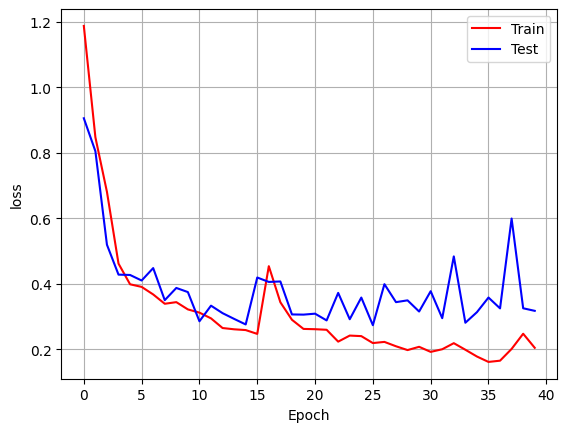

In [ ]:
#with Adam Optimizer

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_test_hist, 'b-', label='Test')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

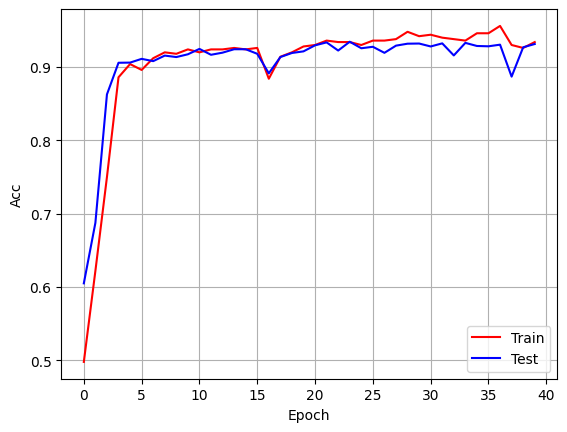

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_test_hist, 'b-', label='Test')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

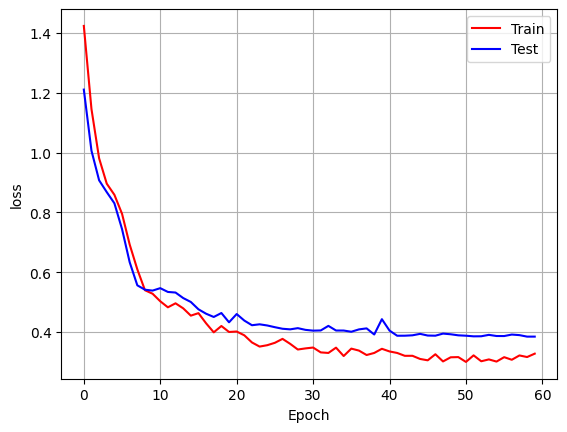

In [ ]:
#with SGD Optimizer

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_test_hist, 'b-', label='Test')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

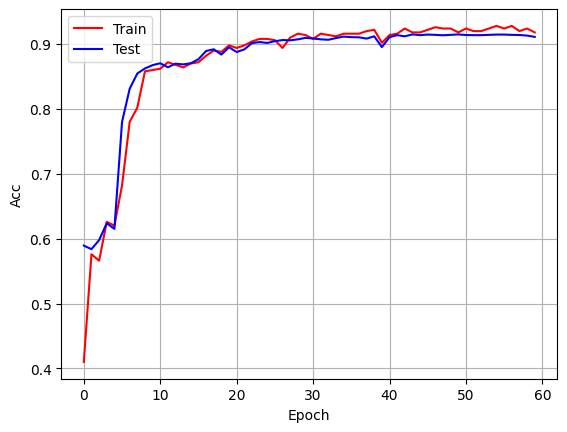

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_test_hist, 'b-', label='Test')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

## Positional Encoding +Transformer Model

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=3000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1)].unsqueeze(0)
        return self.dropout(x)



In [ ]:
class TransformerModelـPe(nn.Module):
    def __init__(self, d_model, nhead, num_enc, dim_feed, dropout, activation):
        super().__init__()
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_enc,
            dim_feedforward=dim_feed,
            dropout=dropout,
            activation=activation,
            batch_first=True
        ).encoder


        self.fc = nn.LazyLinear(num_cls)
        self.linear0 = nn.LazyLinear(d_model)
        self.bn0 = nn.LazyBatchNorm1d()

    def forward(self, x):

        x = self.bn0(self.linear0(x)).relu()
        x = self.pos_encoder(x)
        y = self.encoder(x)
        y = self.fc(y[:, -1])

        return y


In [ ]:
model = TransformerModelـPe(d_model = 16, nhead = 4,  num_enc = 2, dim_feed = 4*16,dropout = 0.2, activation = 'relu').to(device)


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
loss_train_hist = []
loss_test_hist = []

acc_train_hist = []
acc_test_hist = []

best_loss_test = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 40

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_test, acc_test = validation(model,
                                     test_loader,
                                     loss_fn)


  loss_train_hist.append(loss_train)
  loss_test_hist.append(loss_test)

  acc_train_hist.append(acc_train)
  acc_test_hist.append(acc_test)

  if loss_test < best_loss_test:

    # torch.save(model, f'.../best_model/transformer-model.pt')
    best_loss_test = loss_test

  print(f'test: Loss = {loss_test:.4}, Acc = {acc_test:.4}')
  print()

  epoch_counter += 1




Epoch 0: 100%|██████████| 8/8 [00:01<00:00,  4.32batch/s, accuracy=54, loss=1.01]


test: Loss = 0.9395, Acc = 0.5838



Epoch 1: 100%|██████████| 8/8 [00:02<00:00,  3.51batch/s, accuracy=57.4, loss=0.908]


test: Loss = 0.8897, Acc = 0.5838



Epoch 2: 100%|██████████| 8/8 [00:01<00:00,  4.11batch/s, accuracy=73.2, loss=0.724]


test: Loss = 0.4929, Acc = 0.8816



Epoch 3: 100%|██████████| 8/8 [00:02<00:00,  2.85batch/s, accuracy=89.4, loss=0.45]


test: Loss = 0.4027, Acc = 0.9144



Epoch 4: 100%|██████████| 8/8 [00:02<00:00,  3.99batch/s, accuracy=91.8, loss=0.363]


test: Loss = 0.322, Acc = 0.9249



Epoch 5: 100%|██████████| 8/8 [00:02<00:00,  3.66batch/s, accuracy=92.4, loss=0.319]


test: Loss = 0.3223, Acc = 0.9236



Epoch 6: 100%|██████████| 8/8 [00:01<00:00,  4.39batch/s, accuracy=92.2, loss=0.295]


test: Loss = 0.3167, Acc = 0.9204



Epoch 7: 100%|██████████| 8/8 [00:01<00:00,  4.39batch/s, accuracy=92.8, loss=0.271]


test: Loss = 0.3214, Acc = 0.9216



Epoch 8: 100%|██████████| 8/8 [00:02<00:00,  2.86batch/s, accuracy=93.4, loss=0.25]


test: Loss = 0.3086, Acc = 0.9253



Epoch 9: 100%|██████████| 8/8 [00:01<00:00,  4.19batch/s, accuracy=92.8, loss=0.27]


test: Loss = 0.2996, Acc = 0.9236



Epoch 10: 100%|██████████| 8/8 [00:02<00:00,  3.12batch/s, accuracy=92.6, loss=0.265]


test: Loss = 0.356, Acc = 0.9218



Epoch 11: 100%|██████████| 8/8 [00:01<00:00,  4.11batch/s, accuracy=93.2, loss=0.253]


test: Loss = 0.3461, Acc = 0.9207



Epoch 12: 100%|██████████| 8/8 [00:01<00:00,  4.41batch/s, accuracy=93, loss=0.252]


test: Loss = 0.2891, Acc = 0.9242



Epoch 13: 100%|██████████| 8/8 [00:01<00:00,  4.27batch/s, accuracy=94, loss=0.215]


test: Loss = 0.3327, Acc = 0.9233



Epoch 14: 100%|██████████| 8/8 [00:01<00:00,  4.27batch/s, accuracy=93.6, loss=0.233]


test: Loss = 0.3214, Acc = 0.9264



Epoch 15: 100%|██████████| 8/8 [00:02<00:00,  3.87batch/s, accuracy=92.8, loss=0.253]


test: Loss = 0.3311, Acc = 0.9302



Epoch 16: 100%|██████████| 8/8 [00:01<00:00,  4.55batch/s, accuracy=93.8, loss=0.23]


test: Loss = 0.2913, Acc = 0.9367



Epoch 17: 100%|██████████| 8/8 [00:02<00:00,  3.33batch/s, accuracy=95.4, loss=0.197]


test: Loss = 0.2719, Acc = 0.9273



Epoch 18: 100%|██████████| 8/8 [00:02<00:00,  3.93batch/s, accuracy=93.6, loss=0.196]


test: Loss = 0.3112, Acc = 0.9356



Epoch 19: 100%|██████████| 8/8 [00:02<00:00,  3.34batch/s, accuracy=93.4, loss=0.229]


test: Loss = 0.3128, Acc = 0.9242



Epoch 20: 100%|██████████| 8/8 [00:01<00:00,  4.07batch/s, accuracy=92.2, loss=0.305]


test: Loss = 0.2682, Acc = 0.926



Epoch 21: 100%|██████████| 8/8 [00:01<00:00,  4.42batch/s, accuracy=93.4, loss=0.245]


test: Loss = 0.2988, Acc = 0.9364



Epoch 22: 100%|██████████| 8/8 [00:01<00:00,  4.65batch/s, accuracy=94, loss=0.228]


test: Loss = 0.2844, Acc = 0.9338



Epoch 23: 100%|██████████| 8/8 [00:01<00:00,  4.32batch/s, accuracy=93.8, loss=0.221]


test: Loss = 0.3168, Acc = 0.9311



Epoch 24: 100%|██████████| 8/8 [00:02<00:00,  3.44batch/s, accuracy=94.2, loss=0.196]


test: Loss = 0.2762, Acc = 0.9364



Epoch 25: 100%|██████████| 8/8 [00:01<00:00,  4.17batch/s, accuracy=94, loss=0.195]


test: Loss = 0.3019, Acc = 0.9307



Epoch 26: 100%|██████████| 8/8 [00:02<00:00,  3.08batch/s, accuracy=94.6, loss=0.203]


test: Loss = 0.3176, Acc = 0.9342



Epoch 27: 100%|██████████| 8/8 [00:01<00:00,  4.17batch/s, accuracy=94.2, loss=0.233]


test: Loss = 0.3812, Acc = 0.9107



Epoch 28: 100%|██████████| 8/8 [00:02<00:00,  3.86batch/s, accuracy=93.6, loss=0.274]


test: Loss = 0.3437, Acc = 0.9244



Epoch 29: 100%|██████████| 8/8 [00:01<00:00,  4.09batch/s, accuracy=93.8, loss=0.237]


test: Loss = 0.3395, Acc = 0.9302



Epoch 30: 100%|██████████| 8/8 [00:01<00:00,  4.31batch/s, accuracy=94.2, loss=0.23]


test: Loss = 0.2731, Acc = 0.9271



Epoch 31: 100%|██████████| 8/8 [00:01<00:00,  4.44batch/s, accuracy=94, loss=0.21]


test: Loss = 0.3783, Acc = 0.9071



Epoch 32: 100%|██████████| 8/8 [00:02<00:00,  3.96batch/s, accuracy=93.8, loss=0.219]


test: Loss = 0.2659, Acc = 0.9322



Epoch 33: 100%|██████████| 8/8 [00:02<00:00,  3.33batch/s, accuracy=94, loss=0.207]


test: Loss = 0.3221, Acc = 0.9344



Epoch 34: 100%|██████████| 8/8 [00:01<00:00,  4.28batch/s, accuracy=95, loss=0.182]


test: Loss = 0.3008, Acc = 0.934



Epoch 35: 100%|██████████| 8/8 [00:02<00:00,  3.47batch/s, accuracy=95.4, loss=0.182]


test: Loss = 0.3594, Acc = 0.9296



Epoch 36: 100%|██████████| 8/8 [00:01<00:00,  4.10batch/s, accuracy=94.6, loss=0.217]


test: Loss = 0.2865, Acc = 0.9376



Epoch 37: 100%|██████████| 8/8 [00:02<00:00,  3.73batch/s, accuracy=94.6, loss=0.199]


test: Loss = 0.2614, Acc = 0.9389



Epoch 38: 100%|██████████| 8/8 [00:01<00:00,  4.33batch/s, accuracy=95.4, loss=0.173]


test: Loss = 0.3788, Acc = 0.9316



Epoch 39: 100%|██████████| 8/8 [00:01<00:00,  4.20batch/s, accuracy=94.8, loss=0.188]


test: Loss = 0.3292, Acc = 0.936



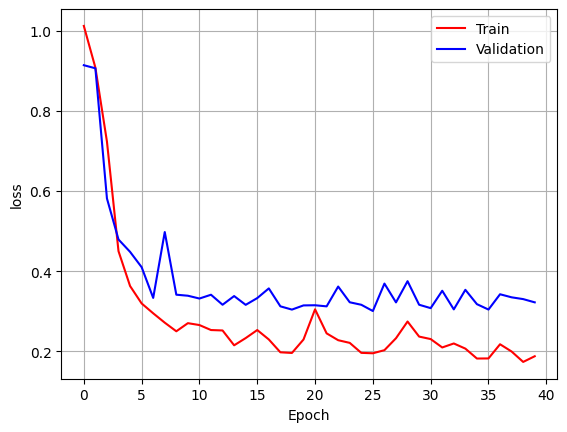

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

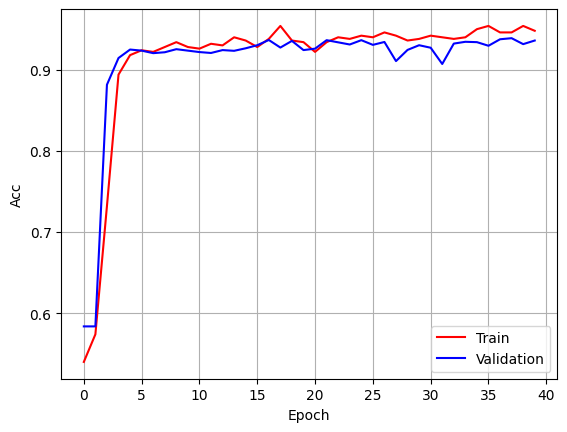

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_test_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

## CNN + Positional Encoding + Transformer Model

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :]
        return self.dropout(x)

class CNN_Transformer_Model(nn.Module):
    def __init__(self, d_model, nhead, num_enc, dim_feed, dropout, activation, num_cls):
        super(CNN_Transformer_Model, self).__init__()

        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, d_model, kernel_size=3, padding=1),
            nn.BatchNorm1d(d_model),
            nn.ReLU()
        )

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # Transformer encoder
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, dim_feed, dropout, activation),
            num_layers=num_enc
        )

        # Fully connected layer for classification
        self.fc = nn.Linear(d_model, num_cls)

    def forward(self, x):
        # CNN expects input in the form (batch_size, in_channels, sequence_length)
        x = x.permute(0, 2, 1)
        x = self.cnn(x)


        x = x.permute(0, 2, 1)

        # اضافه کردن Positional Encoding
        x = self.pos_encoder(x)

        # عبور از ترنسفورمر
        x = self.encoder(x)

        # استفاده از آخرین زمان برای طبقه‌بندی
        x = self.fc(x[:, -1])

        return x


In [ ]:
model = CNN_Transformer_Model(d_model=32, nhead=4, num_enc=2, dim_feed=32*4, dropout=0.2, activation='relu', num_cls=5).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
loss_train_hist = []
loss_test_hist = []

acc_train_hist = []
acc_test_hist = []

best_loss_test = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 40

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # testation
  loss_test, acc_test = validation(model,
                                     test_loader,
                                     loss_fn)


  loss_train_hist.append(loss_train)
  loss_test_hist.append(loss_test)

  acc_train_hist.append(acc_train)
  acc_test_hist.append(acc_test)

  if loss_test < best_loss_test:

    # torch.save(model, f'.../model.pt')
    best_loss_test = loss_test

  print(f'test: Loss = {loss_test:.4}, Acc = {acc_test:.4}')
  print()

  epoch_counter += 1




Epoch 0: 100%|██████████| 8/8 [00:01<00:00,  5.40batch/s, accuracy=55, loss=1.16]


test: Loss = 0.9641, Acc = 0.5838



Epoch 1: 100%|██████████| 8/8 [00:01<00:00,  5.62batch/s, accuracy=85.6, loss=0.608]


test: Loss = 0.7025, Acc = 0.7184



Epoch 2: 100%|██████████| 8/8 [00:01<00:00,  5.01batch/s, accuracy=89.4, loss=0.455]


test: Loss = 0.5174, Acc = 0.8618



Epoch 3: 100%|██████████| 8/8 [00:01<00:00,  5.72batch/s, accuracy=90.2, loss=0.388]


test: Loss = 0.4214, Acc = 0.898



Epoch 4: 100%|██████████| 8/8 [00:01<00:00,  4.88batch/s, accuracy=92, loss=0.345]


test: Loss = 0.3828, Acc = 0.91



Epoch 5: 100%|██████████| 8/8 [00:01<00:00,  5.58batch/s, accuracy=92.2, loss=0.33]


test: Loss = 0.383, Acc = 0.9089



Epoch 6: 100%|██████████| 8/8 [00:01<00:00,  5.51batch/s, accuracy=92.4, loss=0.315]


test: Loss = 0.372, Acc = 0.9109



Epoch 7: 100%|██████████| 8/8 [00:02<00:00,  3.92batch/s, accuracy=92.4, loss=0.316]


test: Loss = 0.364, Acc = 0.9111



Epoch 8: 100%|██████████| 8/8 [00:01<00:00,  5.61batch/s, accuracy=93, loss=0.297]


test: Loss = 0.3571, Acc = 0.9124



Epoch 9: 100%|██████████| 8/8 [00:01<00:00,  5.59batch/s, accuracy=92.6, loss=0.29]


test: Loss = 0.3436, Acc = 0.9124



Epoch 10: 100%|██████████| 8/8 [00:01<00:00,  4.86batch/s, accuracy=92.8, loss=0.268]


test: Loss = 0.3699, Acc = 0.9069



Epoch 11: 100%|██████████| 8/8 [00:01<00:00,  5.45batch/s, accuracy=93, loss=0.281]


test: Loss = 0.3329, Acc = 0.9131



Epoch 12: 100%|██████████| 8/8 [00:01<00:00,  4.94batch/s, accuracy=92.8, loss=0.263]


test: Loss = 0.3148, Acc = 0.9164



Epoch 13: 100%|██████████| 8/8 [00:01<00:00,  5.70batch/s, accuracy=93.4, loss=0.235]


test: Loss = 0.3323, Acc = 0.9167



Epoch 14: 100%|██████████| 8/8 [00:01<00:00,  5.57batch/s, accuracy=94.2, loss=0.242]


test: Loss = 0.3199, Acc = 0.916



Epoch 15: 100%|██████████| 8/8 [00:01<00:00,  4.03batch/s, accuracy=93.8, loss=0.238]


test: Loss = 0.3305, Acc = 0.9167



Epoch 16: 100%|██████████| 8/8 [00:01<00:00,  5.41batch/s, accuracy=93.6, loss=0.231]


test: Loss = 0.3679, Acc = 0.9122



Epoch 17: 100%|██████████| 8/8 [00:01<00:00,  5.29batch/s, accuracy=93.6, loss=0.228]


test: Loss = 0.3267, Acc = 0.9162



Epoch 18: 100%|██████████| 8/8 [00:01<00:00,  4.48batch/s, accuracy=94.4, loss=0.206]


test: Loss = 0.32, Acc = 0.9173



Epoch 19: 100%|██████████| 8/8 [00:01<00:00,  5.32batch/s, accuracy=93.8, loss=0.215]


test: Loss = 0.3308, Acc = 0.9167



Epoch 20: 100%|██████████| 8/8 [00:01<00:00,  5.25batch/s, accuracy=93.6, loss=0.225]


test: Loss = 0.3473, Acc = 0.9116



Epoch 21: 100%|██████████| 8/8 [00:01<00:00,  5.56batch/s, accuracy=93.8, loss=0.211]


test: Loss = 0.3137, Acc = 0.9207



Epoch 22: 100%|██████████| 8/8 [00:01<00:00,  5.53batch/s, accuracy=94, loss=0.205]


test: Loss = 0.3459, Acc = 0.914



Epoch 23: 100%|██████████| 8/8 [00:01<00:00,  4.01batch/s, accuracy=94.4, loss=0.21]


test: Loss = 0.3323, Acc = 0.9167



Epoch 24: 100%|██████████| 8/8 [00:01<00:00,  5.47batch/s, accuracy=94.2, loss=0.197]


test: Loss = 0.3287, Acc = 0.9156



Epoch 25: 100%|██████████| 8/8 [00:01<00:00,  5.58batch/s, accuracy=94.2, loss=0.179]


test: Loss = 0.3183, Acc = 0.9204



Epoch 26: 100%|██████████| 8/8 [00:01<00:00,  4.08batch/s, accuracy=94.4, loss=0.203]


test: Loss = 0.3262, Acc = 0.9189



Epoch 27: 100%|██████████| 8/8 [00:01<00:00,  5.69batch/s, accuracy=94.8, loss=0.201]


test: Loss = 0.3382, Acc = 0.9171



Epoch 28: 100%|██████████| 8/8 [00:01<00:00,  5.38batch/s, accuracy=94.6, loss=0.186]


test: Loss = 0.3231, Acc = 0.9176



Epoch 29: 100%|██████████| 8/8 [00:01<00:00,  4.16batch/s, accuracy=94.4, loss=0.18]


test: Loss = 0.3347, Acc = 0.9184



Epoch 30: 100%|██████████| 8/8 [00:01<00:00,  5.47batch/s, accuracy=94.6, loss=0.176]


test: Loss = 0.3296, Acc = 0.9182



Epoch 31: 100%|██████████| 8/8 [00:02<00:00,  3.91batch/s, accuracy=95, loss=0.161]


test: Loss = 0.3451, Acc = 0.916



Epoch 32: 100%|██████████| 8/8 [00:01<00:00,  5.62batch/s, accuracy=94.2, loss=0.189]


test: Loss = 0.3309, Acc = 0.9162



Epoch 33: 100%|██████████| 8/8 [00:01<00:00,  5.45batch/s, accuracy=94.2, loss=0.177]


test: Loss = 0.3322, Acc = 0.9182



Epoch 34: 100%|██████████| 8/8 [00:01<00:00,  4.79batch/s, accuracy=95.8, loss=0.148]


test: Loss = 0.3534, Acc = 0.9133



Epoch 35: 100%|██████████| 8/8 [00:01<00:00,  5.56batch/s, accuracy=95.6, loss=0.169]


test: Loss = 0.3744, Acc = 0.9124



Epoch 36: 100%|██████████| 8/8 [00:01<00:00,  4.70batch/s, accuracy=93.6, loss=0.166]


test: Loss = 0.328, Acc = 0.9124



Epoch 37: 100%|██████████| 8/8 [00:01<00:00,  5.42batch/s, accuracy=94.6, loss=0.188]


test: Loss = 0.3558, Acc = 0.9127



Epoch 38: 100%|██████████| 8/8 [00:01<00:00,  5.64batch/s, accuracy=94.6, loss=0.165]


test: Loss = 0.3709, Acc = 0.914



Epoch 39: 100%|██████████| 8/8 [00:02<00:00,  3.75batch/s, accuracy=95.6, loss=0.146]


test: Loss = 0.3545, Acc = 0.9136



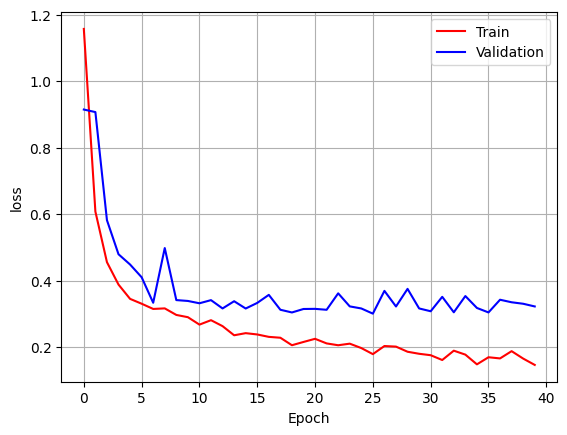

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

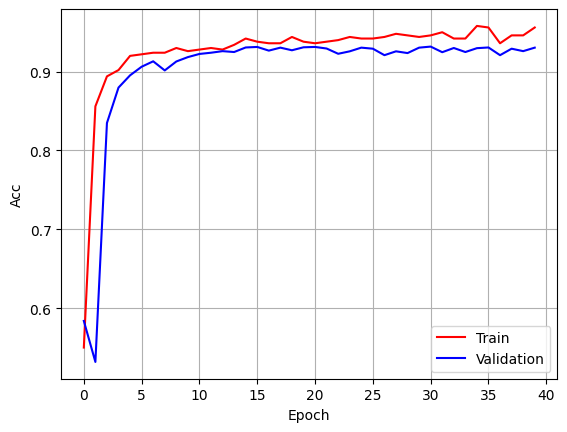

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()